# Predicting displacements and new coordinate frame from 3D points with coordinate frames

### example by  [Tess Smidt](https://blondegeek.github.io/) (GitHub: `blondegeek`)

In [1]:
from functools import partial

import torch
import torch_geometric as tg
import math
import random

import e3nn
from e3nn.point.data_helpers import DataNeighbors
from e3nn import o3, rsh
from e3nn.networks import GatedConvParityNetwork
from e3nn.point.message_passing import Convolution  # torch_geometric style convolution

import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)  # This is the default for e3nn but can be changed if needed

### Load data from other `create_helix_dataset.ipynb` notebook

In [2]:
data_dict = torch.load('datasets/data.torch')
max_radius = data_dict['max_radius']
trainset = data_dict['train']
testset = data_dict['test']
testset_big = data_dict=['test_big']

### Create `torch_geometric.data.DataLoader`s 

In [3]:
batch_size = 32
train_dataloader = tg.data.DataLoader(trainset, batch_size)
test_dataloader = tg.data.DataLoader(testset, batch_size)
test_big_dataloader = tg.data.DataLoader(testset_big, batch_size)

### Set up network to predict displacements and coordinate frame given coordinates and initial frame
We represent a 3D coordinate frame as 3 L=1 objects (L=1 is just a vector given in the order y, z, x -- see `e3nn.o3.xyz_to_irrep()` to get transformation matrix). There may be a better way to represent a coordinate frame (since all vectors are required to be mutually orthogonal), but this is how we do it for now.

In [4]:
# Define the network
Rs_in = [(3, 1, -1)]  # Each point stores three ordered vectors representing the local coordinate system
Rs_out = [(4, 1, -1)]  # Each point predicts a displacement vector and new coordinate system
lmax = 1
mul = 16 # This is the number of channels per irrep in the intermediate layers

model_kwargs = dict(
    Rs_in=Rs_in, Rs_out=Rs_out, mul=mul, layers=3,
    max_radius=max_radius, lmax=lmax, number_of_basis=5,
    convolution=Convolution
)

model = GatedConvParityNetwork(**model_kwargs)

opt = torch.optim.Adam(model.parameters(), 3e-3)
# If you see
# UserWarning: Setting attributes on ParameterList is not supported.
# This is a PyTorch bug that has since been fixed
# https://github.com/pytorch/pytorch/issues/46983

/home/tess/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated function GatedConvParityNetwork.
  del sys.path[0]
/home/tess/.local/lib/python3.7/site-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


### Train!

In [5]:
# device="cuda:2"

# max_iter = 101

# n_norm = 10  # A bit more than the average number of nearest neighbors

# loss_fn = torch.nn.MSELoss()
# model.to(device)

# for i in range(max_iter):
#     loss_cum = torch.zeros(1)
#     for j, data in enumerate(train_dataloader):
#         data.to(device)
#         output = model(data.inital_frames, data.edge_index, data.edge_attr, n_norm=n_norm)
#         loss = loss_fn(output[:, 0:3], data.labels)
#         loss = loss + loss_fn(output[:, 3:], data.label_frames)
#         loss_cum += loss.cpu().detach()
        
#         opt.zero_grad()
#         loss.backward()
#         opt.step()
        
#     if i % 10 == 0:
#         print('Epoch {}: '.format(i), loss_cum / len(train_dataloader))

# torch.save(model.state_dict(), 'models/helix_model_3_layer.npz')

Epoch 0:  tensor([0.2391])
Epoch 10:  tensor([0.0752])
Epoch 20:  tensor([0.0621])
Epoch 30:  tensor([0.0550])
Epoch 40:  tensor([0.0503])
Epoch 50:  tensor([0.0474])
Epoch 60:  tensor([0.0441])
Epoch 70:  tensor([0.0419])
Epoch 80:  tensor([0.0407])
Epoch 90:  tensor([0.0396])
Epoch 100:  tensor([0.0349])


In [12]:
model.load_state_dict(torch.load('models/helix_model_3_layer.npz'))

<All keys matched successfully>

## Check out an training set example

In [29]:
import copy
i = 1
data = copy.deepcopy(trainset[i])  # This is a sloppy way to prevent putting parts of the set on the gpu
data.to(device)
output = model(data.inital_frames, data.edge_index, data.edge_attr, n_norm=n_norm)
loss = loss_fn(output[:, 0:3], data.labels)
loss = loss + loss_fn(output[:, 3:], data.label_frames)
N = data.pos.shape[0]
print(loss)

tensor(0.0322, device='cuda:2', grad_fn=<AddBackward0>)


In [30]:
pos = data.pos.cpu().detach()
init_frame = torch.einsum('nci,ix->ncx', 
                          data.inital_frames.reshape(N, 3, 3).cpu().detach(), 
                          o3.xyz_to_irreducible_basis())
out = torch.einsum('ni,ix->nx', 
                   output[:, 0:3].cpu().detach(), 
                   o3.xyz_to_irreducible_basis())
out_frame = torch.einsum('nci,ix->ncx', 
                         output[:, 3:].reshape(N, 3, 3).cpu().detach(), 
                         o3.xyz_to_irreducible_basis())
true = torch.einsum('ni,ix->nx', 
                    data.labels.cpu().detach(), 
                    o3.xyz_to_irreducible_basis())
true_frame = torch.einsum('nci,ix->ncx',
                          data.label_frames.reshape(N, 3, 3).cpu().detach(),
                          o3.xyz_to_irreducible_basis())

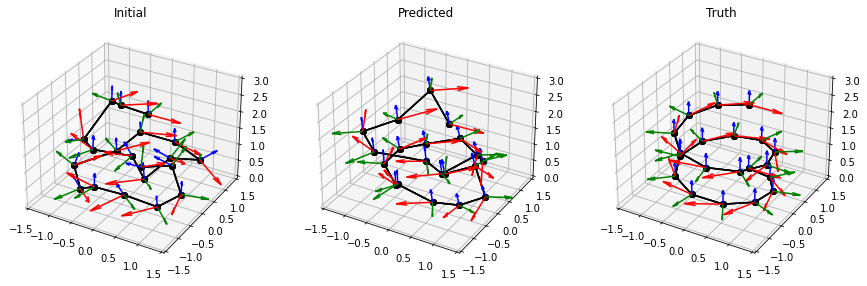

In [39]:
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(15, 5))
axes = [
    fig.add_subplot(1, 3, i + 1, projection='3d')
    for i in range(3)
]

bound = 1.5

for ax in axes:
    ax.set_xlim(-bound, bound)
    ax.set_ylim(-bound, bound)
    ax.set_zlim(0, 2 * bound)

plot_data = [[pos, init_frame], [pos + out, out_frame], [pos + true, true_frame]]
colors = ['red', 'green', 'blue']

scale = 0.75

for i, ((xyz, frame), ax) in enumerate(zip(plot_data, axes)):
    for i in range(3):
        ax.plot(xyz[:, 0], xyz[:, 1], xyz[:, 2], marker='o', color='black')
        frame = frame * scale
        ax.quiver(xyz[:, 0], xyz[:, 1], xyz[:, 2], 
                  frame[:, i, 0], frame[:, i, 1], frame[:, i, 2], 
                  length=1, normalize=False, color=colors[i]) 
        
axes[0].set_title('Initial')
axes[1].set_title('Predicted')
axes[2].set_title('Truth')

plt.show()

Text(0.5, 1.0, 'True Displacements')

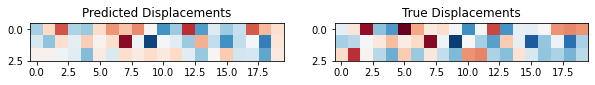

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

vmax = true.abs().max()
ax[0].imshow(out.T, vmin=-vmax, vmax=vmax, cmap='RdBu')
ax[0].set_title('Predicted Displacements')
ax[1].imshow(true.T, vmin=-vmax, vmax=vmax, cmap='RdBu')
ax[1].set_title('True Displacements')

Text(0.5, 1.0, 'True Frames')

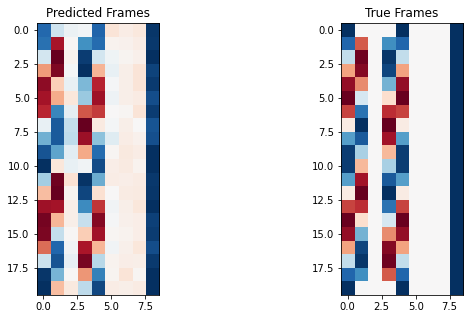

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

vmax = true_frame.abs().max()
ax[0].imshow(out_frame.reshape(N, -1), vmin=-vmax, vmax=vmax, cmap='RdBu')
ax[0].set_title('Predicted Frames')
ax[1].imshow(true_frame.reshape(N, -1), vmin=-vmax, vmax=vmax, cmap='RdBu')
ax[1].set_title('True Frames')

## Check out a test example

In [34]:
import copy
i = 1
data = copy.deepcopy(testset[i])  # This is a sloppy way to prevent putting parts of the set on the gpu
data.to(device)
output = model(data.inital_frames, data.edge_index, data.edge_attr, n_norm=n_norm)
loss = loss_fn(output[:, 0:3], data.labels)
loss = loss + loss_fn(output[:, 3:], data.label_frames)
N = data.pos.shape[0]
print(loss)

tensor(0.0598, device='cuda:2', grad_fn=<AddBackward0>)


In [35]:
pos = data.pos.cpu().detach()
init_frame = torch.einsum('nci,ix->ncx', 
                          data.inital_frames.reshape(N, 3, 3).cpu().detach(), 
                          o3.xyz_to_irreducible_basis())
out = torch.einsum('ni,ix->nx', 
                   output[:, 0:3].cpu().detach(), 
                   o3.xyz_to_irreducible_basis())
out_frame = torch.einsum('nci,ix->ncx', 
                         output[:, 3:].reshape(N, 3, 3).cpu().detach(), 
                         o3.xyz_to_irreducible_basis())
true = torch.einsum('ni,ix->nx', 
                    data.labels.cpu().detach(), 
                    o3.xyz_to_irreducible_basis())
true_frame = torch.einsum('nci,ix->ncx',
                          data.label_frames.reshape(N, 3, 3).cpu().detach(),
                          o3.xyz_to_irreducible_basis())

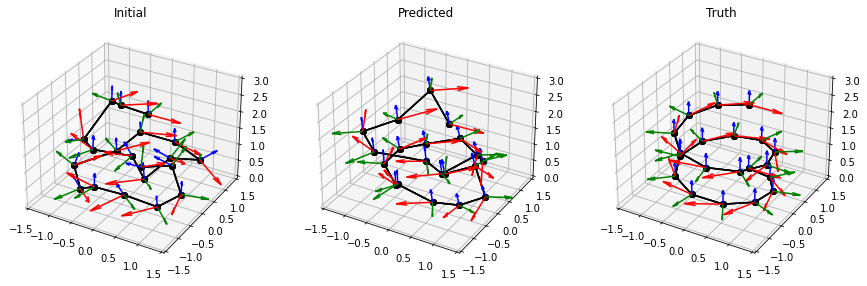

In [40]:
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(15, 5))
axes = [
    fig.add_subplot(1, 3, i + 1, projection='3d')
    for i in range(3)
]

bound = 1.5

for ax in axes:
    ax.set_xlim(-bound, bound)
    ax.set_ylim(-bound, bound)
    ax.set_zlim(0, 2 * bound)

plot_data = [[pos, init_frame], [pos + out, out_frame], [pos + true, true_frame]]
colors = ['red', 'green', 'blue']

scale = 0.75

for i, ((xyz, frame), ax) in enumerate(zip(plot_data, axes)):
    for i in range(3):
        ax.plot(xyz[:, 0], xyz[:, 1], xyz[:, 2], marker='o', color='black')
        frame = frame * scale
        ax.quiver(xyz[:, 0], xyz[:, 1], xyz[:, 2], 
                  frame[:, i, 0], frame[:, i, 1], frame[:, i, 2], 
                  length=1, normalize=False, color=colors[i]) 

axes[0].set_title('Initial')
axes[1].set_title('Predicted')
axes[2].set_title('Truth')
        
plt.show()

Text(0.5, 1.0, 'True Displacements')

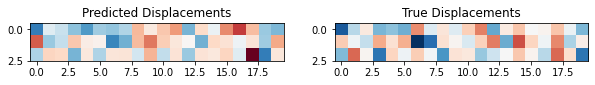

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

vmax = true.abs().max()
ax[0].imshow(out.T, vmin=-vmax, vmax=vmax, cmap='RdBu')
ax[0].set_title('Predicted Displacements')
ax[1].imshow(true.T, vmin=-vmax, vmax=vmax, cmap='RdBu')
ax[1].set_title('True Displacements')

Text(0.5, 1.0, 'True Frames')

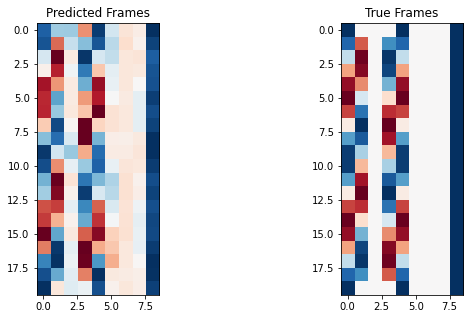

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

vmax = true_frame.abs().max()
ax[0].imshow(out_frame.reshape(N, -1), vmin=-vmax, vmax=vmax, cmap='RdBu')
ax[0].set_title('Predicted Frames')
ax[1].imshow(true_frame.reshape(N, -1), vmin=-vmax, vmax=vmax, cmap='RdBu')
ax[1].set_title('True Frames')